In [1]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pickle
import csv
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')
import gdown
import joblib

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import lightgbm as lgb

import eli5
from eli5.sklearn import PermutationImportance

import os
import glob

# 코드 셀 실행 후 경고를 무시
# import warnings
# warnings.filterwarnings(action='ignore')

### Load files

In [2]:
base_path = "/root/"

dt_train = pd.read_csv(base_path + "train.csv")
dt_test = pd.read_csv(base_path + "test.csv")

In [3]:
extra_data_path = '/root/extra_data/'

### values needed from dt_train before merge

In [4]:
dt_train['구'] = dt_train['시군구'].map(lambda x : x.split()[1])
dt_train['동'] = dt_train['시군구'].map(lambda x : x.split()[2])
# del dt_train['시군구']

dt_test['구'] = dt_test['시군구'].map(lambda x : x.split()[1])
dt_test['동'] = dt_test['시군구'].map(lambda x : x.split()[2])
# del dt_test['시군구']

- >=201307 에서 >=201501 로 수정

In [5]:
dt_train = dt_train[dt_train['계약년월']>=201501]
dt_test = dt_test[dt_test['계약년월']>=201501]

In [6]:
mean_val_by_gu = dt_train.groupby("구")["target"].mean().sort_values(ascending=False)
mean_val_by_dong = dt_train.groupby("동")["target"].mean().sort_values(ascending=False)
std_val_by_gu = dt_train.groupby("구")["target"].std().sort_values(ascending=False)
std_val_by_dong = dt_train.groupby("동")["target"].std().sort_values(ascending=False)

### Load Table from pickle

In [7]:
# pickle에서 데이터프레임 다시 불러오기
with open('/root/data.pickle', 'rb') as f:
    df = pickle.load(f)

In [8]:
df.columns

Index(['번지', '본번', '아파트명', '전용면적(㎡)', '계약년월', '층', '건축년도', '도로명', 'target',
       'is_test', '구', '동', '계약년', '계약월', '평균공시가격', '계약일', 'date'],
      dtype='object')

In [9]:
df = df[df['계약년월']>=201501]

### concat to process

In [10]:
# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
dt_train['is_test'] = 0
dt_test['is_test'] = 1

In [11]:
dt_train['price_per_area'] = dt_train['target'] / dt_train['전용면적(㎡)']

In [12]:
dt = pd.concat([dt_train, dt_test])

In [13]:
dt['is_test'].value_counts()

0    636736
1      9272
Name: is_test, dtype: int64

In [14]:
df['large_std_동'] = df['동']
df.drop(['동'], axis=1, inplace=True)

In [15]:
dt = dt.reset_index()

In [16]:
df['동'] = dt['동']

### 구 동 encoding of df

In [17]:
order1_mean_gu = mean_val_by_gu.index.tolist()
order2_mean_dong = mean_val_by_dong.index.tolist()
order3_std_gu = std_val_by_gu.index.tolist()
order4_std_dong = std_val_by_dong.index.tolist()

# Create a dictionary to map district names to their corresponding label encoded values
gu_mapping1 = {district: label for label, district in enumerate(order1_mean_gu)}
gu_mapping2 = {district: label for label, district in enumerate(order3_std_gu)}
dong_mapping1 = {dong: label for label, dong in enumerate(order2_mean_dong)}
dong_mapping2 = {dong: label for label, dong in enumerate(order4_std_dong)}

df['구_encoded'] = df["구"].map(gu_mapping1)
df['구_std'] = df["구"].map(gu_mapping2)
df['동_encoded'] = df["동"].map(dong_mapping1)
df['동_std'] = df["동"].map(dong_mapping2)

In [18]:
df['yrs_diff'] = df['계약년월'].map(lambda x : x // 100) - df['건축년도']

In [19]:
df['is_public'] = dt["k-전용면적별세대현황(60㎡이하)"].notnull()

### 년도에따라 동, 구별 statistics 추가

In [20]:
# df.drop(['아파트명'], axis=1, inplace=True)

In [21]:
stats = df.groupby(['계약년', '구'])['target'].agg(['std', 'mean', 'max'])
df = df.join(stats, on=['계약년', '구'], rsuffix='_target')

In [22]:
df['계약년과구에따른std'] = df['std']
df['계약년과구에따른mean'] = df['mean']
df['계약년과구에따른max'] = df['max']
df.drop(['std', 'mean', 'max'], axis=1, inplace=True)

In [23]:
stats = df.groupby(['계약년', '동'])['target'].agg(['std', 'mean', 'max'])
df = df.join(stats, on=['계약년', '동'], rsuffix='_target')

In [24]:
df['계약년과동에따른std'] = df['std']
df['계약년과동에따른mean'] = df['mean']
df['계약년과동에따른max'] = df['max']
df.drop(['std', 'mean', 'max'], axis=1, inplace=True)

In [25]:
# '계약년과동에따른std', '계약년과동에따른mean', '계약년과동에따른max'의 null 값을
# '계약년과구에따른std', '계약년과구에따른mean', '계약년과구에따른max'의 값으로 채우기
df['계약년과동에따른std'] = df['계약년과동에따른std'].fillna(df['계약년과구에따른std'])
df['계약년과동에따른mean'] = df['계약년과동에따른mean'].fillna(df['계약년과구에따른mean'])
df['계약년과동에따른max'] = df['계약년과동에따른max'].fillna(df['계약년과구에따른max'])

### yrs_diff 에따른 통계량 추가

In [26]:
df.columns

Index(['번지', '본번', '아파트명', '전용면적(㎡)', '계약년월', '층', '건축년도', '도로명', 'target',
       'is_test', '구', '계약년', '계약월', '평균공시가격', '계약일', 'date', 'large_std_동',
       '동', '구_encoded', '구_std', '동_encoded', '동_std', 'yrs_diff',
       'is_public', '계약년과구에따른std', '계약년과구에따른mean', '계약년과구에따른max',
       '계약년과동에따른std', '계약년과동에따른mean', '계약년과동에따른max'],
      dtype='object')

In [27]:
stats = df.groupby(['yrs_diff', '구'])['target'].agg(['std', 'mean', 'max'])
df = df.join(stats, on=['yrs_diff', '구'], rsuffix='_target')

In [28]:
df['yrs_diff와구에따른std'] = df['std']
df['yrs_diff와구에따른mean'] = df['mean']
df['yrs_diff와구에따른max'] = df['max']
df.drop(['std', 'mean', 'max'], axis=1, inplace=True)

In [29]:
stats = df.groupby(['yrs_diff', '동'])['target'].agg(['std', 'mean', 'max'])
df = df.join(stats, on=['yrs_diff', '동'], rsuffix='_target')

In [30]:
df['yrs_diff와동에따른std'] = df['std']
df['yrs_diff와동에따른mean'] = df['mean']
df['yrs_diff와동에따른max'] = df['max']
df.drop(['std', 'mean', 'max'], axis=1, inplace=True)

In [31]:
# '계약년과동에따른std', '계약년과동에따른mean', '계약년과동에따른max'의 null 값을
# '계약년과구에따른std', '계약년과구에따른mean', '계약년과구에따른max'의 값으로 채우기
df['yrs_diff와동에따른std'] = df['yrs_diff와동에따른std'].fillna(df['yrs_diff와구에따른std'])
df['yrs_diff와동에따른mean'] = df['yrs_diff와동에따른mean'].fillna(df['yrs_diff와구에따른mean'])
df['yrs_diff와동에따른max'] = df['yrs_diff와동에따른max'].fillna(df['yrs_diff와구에따른max'])

In [32]:
df.drop(['동', 'large_std_동', '본번', '계약년과구에따른std', '계약년과구에따른mean', '계약년과구에따른max'], axis=1, inplace=True)

In [33]:
df.columns

Index(['번지', '아파트명', '전용면적(㎡)', '계약년월', '층', '건축년도', '도로명', 'target',
       'is_test', '구', '계약년', '계약월', '평균공시가격', '계약일', 'date', '구_encoded',
       '구_std', '동_encoded', '동_std', 'yrs_diff', 'is_public', '계약년과동에따른std',
       '계약년과동에따른mean', '계약년과동에따른max', 'yrs_diff와구에따른std', 'yrs_diff와구에따른mean',
       'yrs_diff와구에따른max', 'yrs_diff와동에따른std', 'yrs_diff와동에따른mean',
       'yrs_diff와동에따른max'],
      dtype='object')

In [34]:
df.drop(['date'], axis=1, inplace=True)

### KOSPI 종가 delay

In [35]:
# # Use glob to find all files that match the pattern
# file_paths = glob.glob(extra_data_path + "/KOSPI_*.csv")

# # Initialize an empty list to store the dataframes
# dfs = []

# # Iterate over the file paths and read each CSV file into a dataframe
# for file_path in file_paths:
#     kospi_df_yr = pd.read_csv(file_path, encoding="euc-kr")
#     dfs.append(kospi_df_yr)

# kospi_df = pd.concat(dfs, ignore_index=True)
# kospi_df = kospi_df.drop(columns=['시가', '고가', '저가'])

In [36]:
# kospi_df.rename(columns={"일자":"date", "종가":"Close"}, inplace=True)
# kospi_df["date"] = kospi_df['date'].str.replace('/', '-')
# kospi_df["date"] = pd.to_datetime(kospi_df["date"])
# kospi_df.sort_values(by='date', ascending=True, inplace=True)

In [37]:
# kospi_df["Close_delay120d"] = kospi_df["Close"].shift(120)

In [38]:
# df.columns

In [39]:
df['date'] = pd.to_datetime(df['계약년'].astype(str) + '-' + df['계약월'].astype(str) + '-' + df['계약일'].astype(str))

In [40]:
# df = pd.merge(left=df, right=kospi_df, on='date', how='left')

In [41]:
# df.drop(columns=['Close', '대비', '등락률', '거래량', '거래대금', '상장시가총액'], inplace=True)

In [42]:
# df["Close_delay120d"] = df["Close_delay120d"].interpolate(method='linear', axis=0)

In [43]:
df['date'] = df['date'].astype(str)

In [44]:
df.drop(['구', 'yrs_diff와구에따른std', 'yrs_diff와구에따른mean', 
       'yrs_diff와구에따른max','구_std', '동_std'], axis=1, inplace=True)

In [45]:
df.drop(['계약년월', '계약년', '계약월', '계약일', '계약년과동에따른std', '계약년과동에따른mean', '계약년과동에따른max'], axis=1, inplace=True)

In [46]:
df.columns

Index(['번지', '아파트명', '전용면적(㎡)', '층', '건축년도', '도로명', 'target', 'is_test',
       '평균공시가격', '구_encoded', '동_encoded', 'yrs_diff', 'is_public',
       'yrs_diff와동에따른std', 'yrs_diff와동에따른mean', 'yrs_diff와동에따른max', 'date'],
      dtype='object')

In [47]:
df['price_per_area'] = df['target'] / df['전용면적(㎡)']

In [48]:
df['price_per_area'].isnull().sum()

9272

In [49]:
# Assuming '도로명' column contains strings representing roads
# Assuming 'price_per_area' column contains numerical values

# Sort the DataFrame by '도로명' and any relevant time column (if available)
df_sorted = df.sort_values(by=['도로명', 'date'], ascending=True)

# Forward fill missing values in 'price_per_area' based on '도로명'
df['price_per_area'] = df_sorted.groupby('도로명')['price_per_area'].ffill()

# If there are any remaining missing values after forward fill, you can backfill them
df['price_per_area'] = df['price_per_area'].bfill()

In [50]:
df['price_per_area'].isnull().sum()

0

In [51]:
df['is_test'].value_counts()

0    636736
1      9272
Name: is_test, dtype: int64

In [52]:
df.columns

Index(['번지', '아파트명', '전용면적(㎡)', '층', '건축년도', '도로명', 'target', 'is_test',
       '평균공시가격', '구_encoded', '동_encoded', 'yrs_diff', 'is_public',
       'yrs_diff와동에따른std', 'yrs_diff와동에따른mean', 'yrs_diff와동에따른max', 'date',
       'price_per_area'],
      dtype='object')

In [53]:
df.drop(['is_public'], axis=1, inplace=True)

### Feature Engineering

### Train

In [54]:
df.columns

Index(['번지', '아파트명', '전용면적(㎡)', '층', '건축년도', '도로명', 'target', 'is_test',
       '평균공시가격', '구_encoded', '동_encoded', 'yrs_diff', 'yrs_diff와동에따른std',
       'yrs_diff와동에따른mean', 'yrs_diff와동에따른max', 'date', 'price_per_area'],
      dtype='object')

In [55]:
df_train = df.loc[df['is_test']==0, :]
df_test = df.loc[df['is_test']==1, :]

df_train.drop(['is_test'], axis=1, inplace=True)
df_test.drop(['is_test'], axis=1, inplace=True)
print(df_train.shape, df_test.shape)

(636736, 16) (9272, 16)


In [56]:
# 변수 삭제 및 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns = []
categorical_columns = []

for column in df_train.columns:
    if pd.api.types.is_numeric_dtype(df_train[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['전용면적(㎡)', '층', '건축년도', 'target', '평균공시가격', '구_encoded', '동_encoded', 'yrs_diff', 'yrs_diff와동에따른std', 'yrs_diff와동에따른mean', 'yrs_diff와동에따른max', 'price_per_area']
범주형 변수: ['번지', '아파트명', '도로명', 'date']


In [57]:
# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm(categorical_columns):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( df_train[col].astype(str) )
    df_train[col] = lbl.transform(df_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(df_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    df_test[col] = lbl.transform(df_test[col].astype(str))

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:01<00:00,  3.83it/s]


In [58]:
y_train = df_train['target']
X_train = df_train.drop(['target'], axis=1)

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2023)

In [59]:
df_train0 = df_train[(df_train['전용면적(㎡)']<60)]
df_train60 = df_train[(df_train['전용면적(㎡)']>=60)&(df_train['전용면적(㎡)']<135)]
df_train135 = df_train[(df_train['전용면적(㎡)']>=135)]

In [60]:
df_train0.sort_values(by= '전용면적(㎡)', ascending=False)
df_train60.sort_values(by= '전용면적(㎡)', ascending=False)
df_train135.sort_values(by= '전용면적(㎡)', ascending=False)

,번지,아파트명,전용면적(㎡),층,건축년도,도로명,target,평균공시가격,구_encoded,동_encoded,yrs_diff,yrs_diff와동에따른std,yrs_diff와동에따른mean,yrs_diff와동에따른max,date,price_per_area
547784,1726,6426,424.32,10,1998,1617,498000.0,321942.105263,0,130.0,18,53448.549796,85095.049505,498000.0,465,1173.642534
60088,1165,4575,395.06,10,1996,3292,290000.0,207557.894737,1,32.0,22,35321.884950,57323.263889,290000.0,1336,734.065712
288524,2488,4933,317.36,9,1972,7182,175000.0,115991.666667,2,274.0,49,35957.758681,27152.631579,175000.0,2294,551.424250
381470,2488,4933,317.36,2,1972,7182,150000.0,115991.666667,2,260.0,48,132848.924498,239956.342857,640000.0,1981,472.649357
751298,2488,4933,317.36,2,1972,7182,85000.0,115991.666667,2,NaN,43,41114.162197,101770.507937,233500.0,107,267.834636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588481,5665,3881,135.00,15,1997,3057,53500.0,47264.792899,24,66.0,19,16136.817663,47111.718750,119000.0,467,396.296296
698469,5665,3881,135.00,22,1997,3057,49500.0,47264.792899,24,NaN,18,21654.891038,46442.330097,147000.0,26,366.666667
698476,5665,3881,135.00,6,1997,3057,48500.0,47264.792899,24,NaN,18,21654.891038,46442.330097,147000.0,39,359.259259
698477,5665,3881,135.00,1,1997,3057,44250.0,47264.792899,24,NaN,18,21654.891038,46442.330097,147000.0,39,327.777778


In [61]:
y_train0 = df_train0['target']
X_train0 = df_train0.drop(['target'], axis=1)


y_train60 = df_train60['target']
X_train60 = df_train60.drop(['target'], axis=1)

y_train135 = df_train135['target']
X_train135 = df_train135.drop(['target'], axis=1)


# Split the data into train and validation sets
X_train0, X_val0, y_train0, y_val0 = train_test_split(X_train0, y_train0, test_size=0.2, random_state=2023)
X_train60, X_val60, y_train60, y_val60 = train_test_split(X_train60, y_train60, test_size=0.2, random_state=2023)

In [70]:
print(X_train0.shape, X_val0.shape)
print(X_train60.shape, X_val60.shape)

(196015, 15) (49004, 15)
(291853, 15) (72964, 15)


In [71]:
gbm0 = lgb.LGBMRegressor(n_estimators=5000, max_depth=50, num_leaves=600, min_child_samples=50,
                            feature_fraction=0.7,
                            bagging_fraction=0.9, verbosity=-1)



gbm60 = lgb.LGBMRegressor(n_estimators=5000, max_depth=50, num_leaves=600, min_child_samples=50,
                            feature_fraction=0.7,
                            bagging_fraction=0.9, verbosity=-1)

In [72]:
gbm0.fit(
        X_train0, y_train0, 
        eval_set=[(X_train0, y_train0), (X_val0, y_val0)], 
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=50),
                   lgb.log_evaluation(period=100, show_stdv=True)]
        )


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 970.887	training's l2: 942621	valid_1's rmse: 1597.33	valid_1's l2: 2.55146e+06
[200]	training's rmse: 753.934	training's l2: 568416	valid_1's rmse: 1513.63	valid_1's l2: 2.29106e+06
[300]	training's rmse: 648.876	training's l2: 421040	valid_1's rmse: 1493.31	valid_1's l2: 2.22997e+06
[400]	training's rmse: 577.677	training's l2: 333711	valid_1's rmse: 1484.66	valid_1's l2: 2.20423e+06
[500]	training's rmse: 527.538	training's l2: 278296	valid_1's rmse: 1481.71	valid_1's l2: 2.19546e+06
Early stopping, best iteration is:
[460]	training's rmse: 545.937	training's l2: 298048	valid_1's rmse: 1480.58	valid_1's l2: 2.19213e+06


LGBMRegressor(bagging_fraction=0.9, feature_fraction=0.7, max_depth=50,
              min_child_samples=50, n_estimators=5000, num_leaves=600,
              verbosity=-1)

In [73]:
gbm60.fit(
        X_train60, y_train60, 
        eval_set=[(X_train60, y_train60), (X_val60, y_val60)], 
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=50),
                   lgb.log_evaluation(period=100, show_stdv=True)]
        )

Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 1503.64	training's l2: 2.26092e+06	valid_1's rmse: 2012.39	valid_1's l2: 4.0497e+06
[200]	training's rmse: 1107.18	training's l2: 1.22584e+06	valid_1's rmse: 1814.18	valid_1's l2: 3.29125e+06
[300]	training's rmse: 926.215	training's l2: 857874	valid_1's rmse: 1763.24	valid_1's l2: 3.10903e+06
[400]	training's rmse: 809.68	training's l2: 655582	valid_1's rmse: 1740.7	valid_1's l2: 3.03004e+06
[500]	training's rmse: 727.671	training's l2: 529505	valid_1's rmse: 1729.22	valid_1's l2: 2.99021e+06
[600]	training's rmse: 661.16	training's l2: 437132	valid_1's rmse: 1724.58	valid_1's l2: 2.97419e+06
[700]	training's rmse: 609.646	training's l2: 371668	valid_1's rmse: 1721.86	valid_1's l2: 2.96482e+06
[800]	training's rmse: 567.851	training's l2: 322455	valid_1's rmse: 1720.79	valid_1's l2: 2.96111e+06
[900]	training's rmse: 532.375	training's l2: 283423	valid_1's rmse: 1721.76	valid_1's l2: 2.96445e+06
Early 

LGBMRegressor(bagging_fraction=0.9, feature_fraction=0.7, max_depth=50,
              min_child_samples=50, n_estimators=5000, num_leaves=600,
              verbosity=-1)

### 135만 다르게 접근해야할 것 같음

In [74]:
# X_train135, y_train135, X_val135

In [75]:
# from sklearn.model_selection import KFold, cross_val_score

In [76]:
# kf = KFold(n_splits=5, random_state=42, shuffle=True)

In [77]:
X_train135, X_val135, y_train135, y_val135 = train_test_split(X_train135, y_train135, test_size=0.1, random_state=2023)

In [78]:
gbm135 = lgb.LGBMRegressor(n_estimators=5000, max_depth=20, num_leaves=600, min_child_samples=10,
                            feature_fraction=0.7,
                            bagging_fraction=0.9, verbosity=-1)

In [80]:
# X_train135.drop('date', axis=1, inplace=True)
# X_val135.drop('date', axis=1, inplace=True)

In [81]:
gbm135.fit(
        X_train135, y_train135, 
        eval_set=[(X_train135, y_train135), (X_val135, y_val135)], 
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=50),
                   lgb.log_evaluation(period=100, show_stdv=True)]
        )

Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 2451.19	training's l2: 6.00834e+06	valid_1's rmse: 8085.56	valid_1's l2: 6.53762e+07
[200]	training's rmse: 1514.86	training's l2: 2.2948e+06	valid_1's rmse: 7934.15	valid_1's l2: 6.29507e+07
Early stopping, best iteration is:
[228]	training's rmse: 1323.56	training's l2: 1.75181e+06	valid_1's rmse: 7913.78	valid_1's l2: 6.26278e+07


LGBMRegressor(bagging_fraction=0.9, feature_fraction=0.7, max_depth=20,
              min_child_samples=10, n_estimators=5000, num_leaves=600,
              verbosity=-1)

In [82]:
X_test = df_test.drop(['target'], axis=1)
# X_test = X_test.drop(columns='Close_delay120d')
# X_test = X_test.drop(columns='계약년월')

X_test

,번지,아파트명,전용면적(㎡),층,건축년도,도로명,평균공시가격,구_encoded,동_encoded,yrs_diff,yrs_diff와동에따른std,yrs_diff와동에따른mean,yrs_diff와동에따른max,date,price_per_area
1118822,4682,319,79.9700,5,1987,6025,120960.000000,0,NaN,36,78047.338623,180069.893485,540000.0,3097,2701.012880
1118823,4657,320,108.2017,10,2021,464,155775.000000,0,NaN,2,103660.430459,169122.259048,1450000.0,3117,2268.293789
1118824,4658,324,161.0000,15,1984,462,182537.777778,0,NaN,39,88521.744758,209776.336634,595000.0,3099,2389.160203
1118825,4658,324,133.4600,14,1984,462,182537.777778,0,NaN,39,88521.744758,209776.336634,595000.0,3112,2389.160203
1118826,4658,324,104.4300,6,1984,462,182537.777778,0,NaN,39,88521.744758,209776.336634,595000.0,3120,2389.160203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,5716,3617,84.6500,13,2014,5423,39021.326676,21,NaN,9,22509.608301,41454.276316,208000.0,3090,813.487385
1128090,5716,3617,84.6200,12,2014,5423,39021.326676,21,NaN,9,22509.608301,41454.276316,208000.0,3096,813.487385
1128091,5716,3617,101.6500,12,2014,5423,39021.326676,21,NaN,9,22509.608301,41454.276316,208000.0,3129,813.487385
1128092,5716,3617,84.9400,18,2014,5423,39021.326676,21,NaN,9,22509.608301,41454.276316,208000.0,3135,813.487385


In [83]:
X_test0 = X_test[(X_test['전용면적(㎡)']<60)]
X_test60 = X_test[(X_test['전용면적(㎡)']>=60)&(X_test['전용면적(㎡)']<135)]
X_test135 = X_test[(X_test['전용면적(㎡)']>=135)]

In [85]:
X_train135.columns

Index(['번지', '아파트명', '전용면적(㎡)', '층', '건축년도', '도로명', '평균공시가격', '구_encoded',
       '동_encoded', 'yrs_diff', 'yrs_diff와동에따른std', 'yrs_diff와동에따른mean',
       'yrs_diff와동에따른max', 'price_per_area'],
      dtype='object')

In [86]:
X_test135.columns

Index(['번지', '아파트명', '전용면적(㎡)', '층', '건축년도', '도로명', '평균공시가격', '구_encoded',
       '동_encoded', 'yrs_diff', 'yrs_diff와동에따른std', 'yrs_diff와동에따른mean',
       'yrs_diff와동에따른max', 'date', 'price_per_area'],
      dtype='object')

In [87]:
X_test135.drop(['date'], axis=1, inplace=True)

In [88]:
real_test_pred0 = gbm0.predict(X_test0)
real_test_pred60 = gbm60.predict(X_test60)
real_test_pred135 = gbm135.predict(X_test135)


In [89]:
X_test0['target'] = real_test_pred0
X_test60['target'] = real_test_pred60
X_test135['target'] = real_test_pred135


In [90]:
# concat

concat_test = pd.concat([X_test0, X_test60, X_test135], axis=0)
concat_test = concat_test.sort_index()
concat_test


,번지,아파트명,전용면적(㎡),층,건축년도,도로명,평균공시가격,구_encoded,동_encoded,yrs_diff,yrs_diff와동에따른std,yrs_diff와동에따른mean,yrs_diff와동에따른max,date,price_per_area,target
1118822,4682,319,79.9700,5,1987,6025,120960.000000,0,NaN,36,78047.338623,180069.893485,540000.0,3097.0,2701.012880,217429.595113
1118823,4657,320,108.2017,10,2021,464,155775.000000,0,NaN,2,103660.430459,169122.259048,1450000.0,3117.0,2268.293789,259467.499161
1118824,4658,324,161.0000,15,1984,462,182537.777778,0,NaN,39,88521.744758,209776.336634,595000.0,NaN,2389.160203,353800.340815
1118825,4658,324,133.4600,14,1984,462,182537.777778,0,NaN,39,88521.744758,209776.336634,595000.0,3112.0,2389.160203,323993.633157
1118826,4658,324,104.4300,6,1984,462,182537.777778,0,NaN,39,88521.744758,209776.336634,595000.0,3120.0,2389.160203,243487.148035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,5716,3617,84.6500,13,2014,5423,39021.326676,21,NaN,9,22509.608301,41454.276316,208000.0,3090.0,813.487385,72252.967454
1128090,5716,3617,84.6200,12,2014,5423,39021.326676,21,NaN,9,22509.608301,41454.276316,208000.0,3096.0,813.487385,72402.266820
1128091,5716,3617,101.6500,12,2014,5423,39021.326676,21,NaN,9,22509.608301,41454.276316,208000.0,3129.0,813.487385,84624.245425
1128092,5716,3617,84.9400,18,2014,5423,39021.326676,21,NaN,9,22509.608301,41454.276316,208000.0,3135.0,813.487385,72009.096827


In [91]:

# X_test에서 target만 분리.

ttt = concat_test.loc[:,'target']
ttt = pd.DataFrame(ttt)

ttt= ttt.reset_index()

preds_df= ttt.drop(columns='index')
preds_df= ttt.drop(columns='index')

preds_df2 = pd.DataFrame(preds_df['target'].astype(int), columns=["target"])
preds_df2

preds_df2.to_csv('gu-dong-encoded_0401_9am_yoon.csv', index=False)



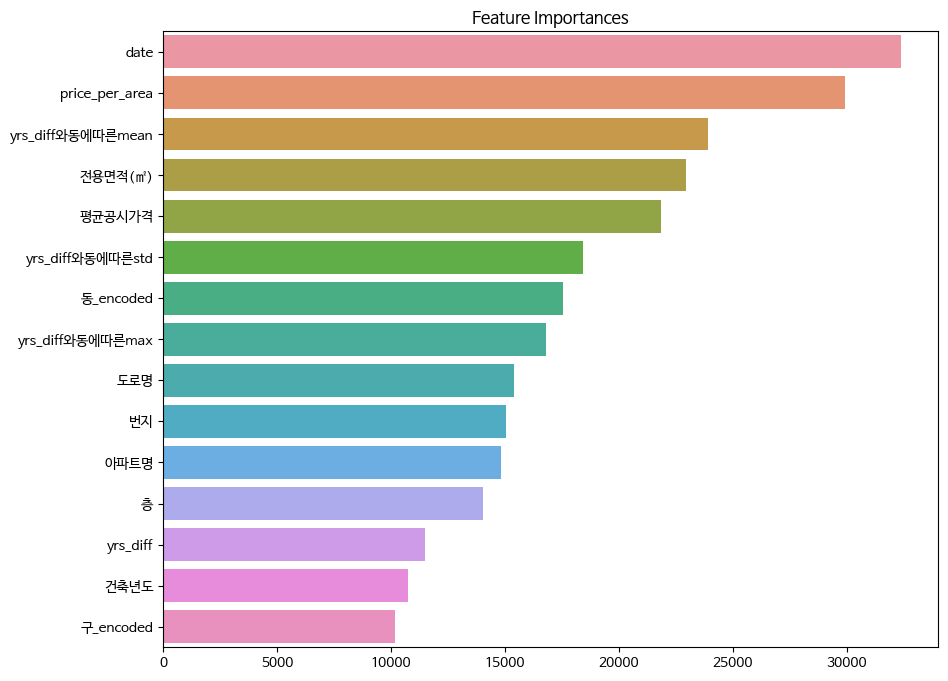

In [92]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(gbm0.feature_importances_, index=list(X_train0.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

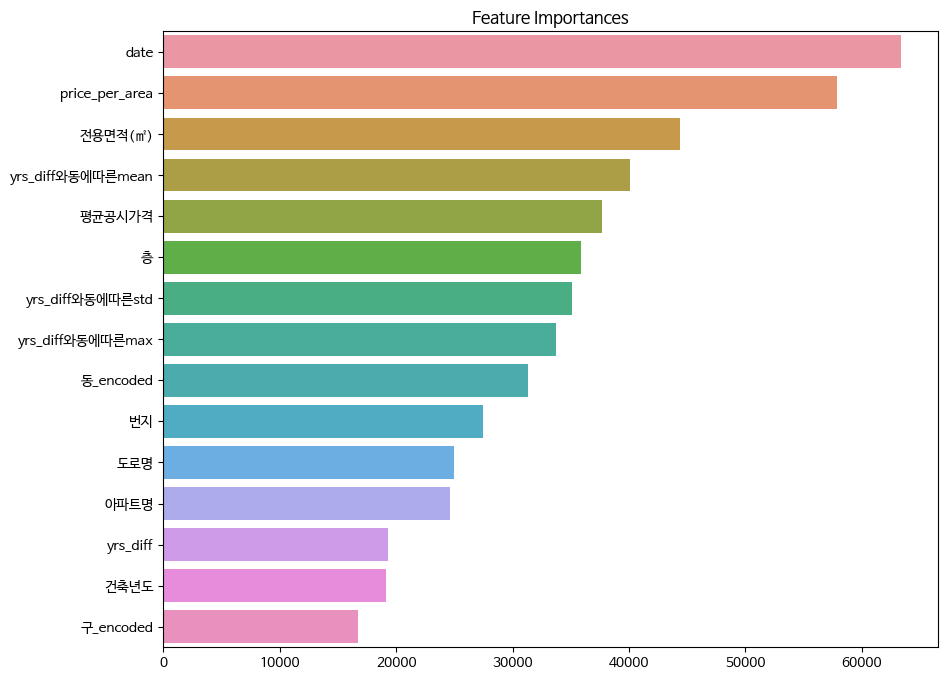

In [93]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(gbm60.feature_importances_, index=list(X_train60.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

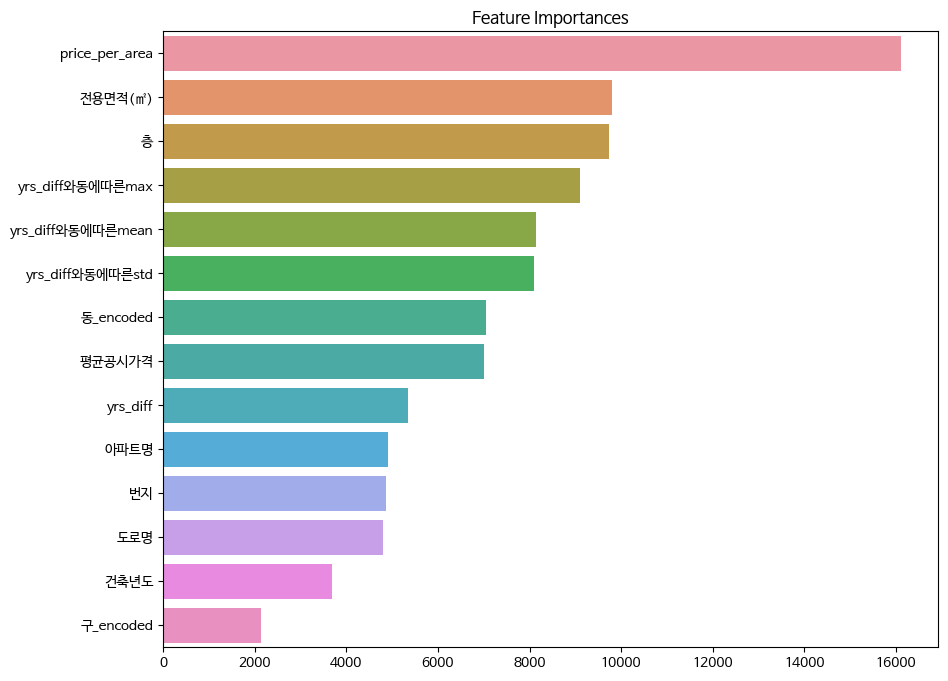

In [94]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(gbm135.feature_importances_, index=list(X_train135.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [95]:
# Permutation importance 방법을 변수 선택에 이용해보겠습니다.
perm = PermutationImportance(gbm0,        # 위에서 학습된 모델을 이용하겠습니다.
                             scoring = "neg_mean_squared_error",        # 평가 지표로는 회귀문제이기에 negative rmse를 사용합니다. (neg_mean_squared_error : 음의 평균 제곱 오차)
                             random_state = 42,
                             n_iter=3).fit(X_val0, y_val0)
eli5.show_weights(perm, feature_names = X_val0.columns.tolist())    # valid data에 대해 적합시킵니다.

Weight,Feature
995534984.3851 ± 8775977.6511,price_per_area
257944264.2015 ± 3818409.2239,전용면적(㎡)
19653811.4643 ± 428237.4157,date
11075521.0336 ± 50872.1029,평균공시가격
4607130.5740 ± 37649.4347,구_encoded
2671217.6642 ± 83879.4682,yrs_diff와동에따른mean
2056029.3850 ± 83220.1738,건축년도
1606176.0567 ± 65523.6985,yrs_diff
1362059.1717 ± 86638.1617,yrs_diff와동에따른max
1212079.0858 ± 34332.4334,번지


In [96]:
# Permutation importance 방법을 변수 선택에 이용해보겠습니다.
perm = PermutationImportance(gbm60,        # 위에서 학습된 모델을 이용하겠습니다.
                             scoring = "neg_mean_squared_error",        # 평가 지표로는 회귀문제이기에 negative rmse를 사용합니다. (neg_mean_squared_error : 음의 평균 제곱 오차)
                             random_state = 42,
                             n_iter=3).fit(X_val60, y_val60)
eli5.show_weights(perm, feature_names = X_val.columns.tolist())    # valid data에 대해 적합시킵니다.

Weight,Feature
2951140684.3838 ± 27180886.8622,price_per_area
398188316.4554 ± 8332582.3265,전용면적(㎡)
28493705.9016 ± 807133.3069,date
14906980.2203 ± 229989.0811,평균공시가격
8422709.5635 ± 346473.8946,yrs_diff와동에따른max
7370502.0471 ± 239136.4418,구_encoded
3441095.9441 ± 104603.4291,yrs_diff와동에따른mean
2791188.7407 ± 32556.9577,건축년도
1789220.7733 ± 73968.3540,동_encoded
1247258.7166 ± 48485.5784,yrs_diff


In [97]:
# Permutation importance 방법을 변수 선택에 이용해보겠습니다.
perm = PermutationImportance(gbm135,        # 위에서 학습된 모델을 이용하겠습니다.
                             scoring = "neg_mean_squared_error",        # 평가 지표로는 회귀문제이기에 negative rmse를 사용합니다. (neg_mean_squared_error : 음의 평균 제곱 오차)
                             random_state = 42,
                             n_iter=3).fit(X_val135, y_val135)
eli5.show_weights(perm, feature_names = X_val135.columns.tolist())    # valid data에 대해 적합시킵니다.

Weight,Feature
10740366893.0041 ± 399469845.8958,price_per_area
1648684185.4615 ± 58420039.3453,전용면적(㎡)
501919965.4185 ± 21986092.3992,yrs_diff와동에따른max
402576945.3362 ± 17268786.5425,평균공시가격
62452618.2977 ± 5553828.3406,yrs_diff와동에따른std
61696348.4487 ± 7607859.2127,yrs_diff와동에따른mean
59851401.6504 ± 12193801.4669,동_encoded
47014133.8999 ± 501087.6653,yrs_diff
25136784.3971 ± 1939947.7788,건축년도
20700284.7778 ± 646490.3102,도로명


In [98]:
preds_df2.describe().round(2)

,target
count,9272.00
mean,108421.13
std,76610.98
min,7583.00
25%,60518.75
50%,87928.50
75%,133898.00
max,1041582.00
